# Load Libraries

In [38]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import spacy

# Read Data

In [3]:
name_column=['target','id','date', 'flag','user', 'text']
twitter_df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv"
                , encoding = 'ISO-8859-1', names = name_column)
twitter_df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
twitter_df.shape

(1600000, 6)

In [5]:
twitter_df.isna().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [6]:
df = twitter_df[['target','text']]
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [7]:
df['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [8]:
df.loc[df['target'] == 4, 'target'] = 1

In [9]:
df['target'].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

# Data Preprocessing

In [10]:
! python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 37.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [11]:
nlp = spacy.load("en_core_web_md")

In [12]:
df['text'][3]

'my whole body feels itchy and like its on fire '

In [13]:
# 1) tokenization
doc = nlp(df['text'][3])

In [14]:
for token in doc:
    print(token)

my
whole
body
feels
itchy
and
like
its
on
fire


In [15]:
# 2) Stemming and lemmatization 

for token in doc:
    print(f"Word: {token} | -> {token.lemma_}")

Word: my | -> my
Word: whole | -> whole
Word: body | -> body
Word: feels | -> feel
Word: itchy | -> itchy
Word: and | -> and
Word: like | -> like
Word: its | -> its
Word: on | -> on
Word: fire | -> fire


In [16]:
# 3) Stop words

for token in doc:
    if token.is_stop or token.is_punct:
        print(token)

my
whole
and
its
on


In [17]:
# Patterns for URL and tags
url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
tag_pattern = r"@[^\s]+"

# Emoji dictionary for replacement
emojis = {
    ':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
    ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
    ':-@': 'shocked', ':@': 'shocked', ':-$': 'confused', ':\\': 'annoyed',
    ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
    '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
    '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
    ';-)': 'wink', 'O:-)': 'angel', 'O*-)': 'angel', '(:-D': 'gossip', '=^.^=': 'cat'
}

def replacing_emojis(text):
    return ' '.join(emojis.get(word, word) for word in text.split())


def cleanned_text(text):
    # Step 1: Remove URLs
    text = re.sub(url_pattern, '', text)
   
    # Step 2: Replace emojis
    text = replacing_emojis(text)
    
    # Step 3: Remove tags
    text = re.sub(tag_pattern, '', text)
    
    return text  

In [18]:
df['text'] = df['text'].apply(cleanned_text)

/tmp/ipykernel_36/1310264031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(cleanned_text)


In [19]:
df.head()

,target,text
0,0,"- Awww, that's a bummer. You shoulda got Davi..."
1,0,is upset that he can't update his Facebook by ...
2,0,I dived many times for the ball. Managed to s...
3,0,my whole body feels itchy and like its on fire
4,0,"no, it's not behaving at all. i'm mad. why am..."


In [20]:
def preprocess(text):
    # Tokenize, remove stop words and lemmatize
    filtered_tokens = []
    doc = nlp(text)
    
    for token in doc:
        if not token.is_stop and not token.is_punct:
            filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens)


In [21]:
print(df['text'][3])
procces_txt = preprocess(df['text'][3])
print(procces_txt)

my whole body feels itchy and like its on fire
body feel itchy like fire


In [22]:
sample_size = 100000
df = df.sample(n=sample_size, random_state=42)


In [23]:
df.shape

(100000, 2)

In [24]:
df

,target,text
541200,0,AHHH I HOPE YOUR OK!!!
750,0,"cool , i have no tweet apps for my razr 2"
766711,0,i know just family drama. its lame.hey next t...
285055,0,School email won't open and I have geography s...
705995,0,upper airways problem
...,...,...
159217,0,finallytryingto download evernote on my bberry...
298540,0,too late. guess i'm being stuffed in the trunk.
839945,1,On the way to target with mah sistaaa
732586,0,"Hip is worse today, moving my leg causes pain...."


In [25]:
# Let's apply the preprocess funtion on the whole dataframe! 

df['preprocessed_text'] = df['text'].apply(preprocess)
df.head()

,target,text,preprocessed_text
541200,0,AHHH I HOPE YOUR OK!!!,AHHH HOPE ok
750,0,"cool , i have no tweet apps for my razr 2",cool tweet app razr 2
766711,0,i know just family drama. its lame.hey next t...,know family drama lame.hey time u hang kim n...
285055,0,School email won't open and I have geography s...,school email will open geography stuff revise ...
705995,0,upper airways problem,upper airway problem


In [28]:
df['target'].value_counts()

target
1    50057
0    49943
Name: count, dtype: int64

# Split Data 

In [26]:
X = df['preprocessed_text']
Y = df['target']

In [29]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1,  random_state = 42, stratify = df['target'] )

In [30]:
print(f'x train shape {x_train.shape}, x test shape {x_test.shape}')
print(f'y train shape {y_train.shape}, y test shape {y_test.shape}')

x train shape (90000,), x test shape (10000,)
y train shape (90000,), y test shape (10000,)


# Convert text column to numeric vector

In [31]:
v = TfidfVectorizer()

x_train_v = v.fit_transform(x_train)
x_test_v = v.transform(x_test)

# Build Models

In [32]:
def fit_predict(model, x_train, y_train, x_test, y_test):
    
    # Make model fit data
    model.fit(x_train, y_train)
    
    # Get Score on train and test data
    train_score = model.score(x_train, y_train)
    test_score = model.score(x_test, y_test)
    print(f'train score is {train_score}, test score is {test_score}')
    
    # Make model predict on test data
    test_prediction = model.predict(x_test)
    # Get accuracy, confusion matrix and classification report
    accuracy = accuracy_score(y_test, test_prediction) 
    cf_matrix = confusion_matrix(y_test, test_prediction)
    cl_report = classification_report(y_test, test_prediction)
    
    # Plot confusion matrix
    plt.figure(figsize=(7,7))
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Show accuracy and classification report
    print(f'accuracy: {accuracy}\nclassification report:\n{cl_report}', '\n\n')
    
    return model

In [40]:
models = {
    'LogisticRegression': LogisticRegression(),
    'BernoulliNB': BernoulliNB(),
     'LinearSVC' : LinearSVC()
}

LogisticRegression:



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


train score is 0.8126222222222222, test score is 0.7541


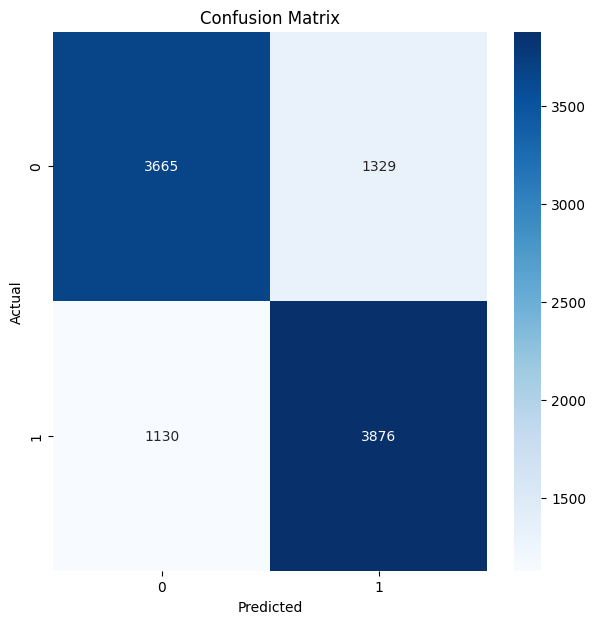

accuracy: 0.7541
classification report:
              precision    recall  f1-score   support

           0       0.76      0.73      0.75      4994
           1       0.74      0.77      0.76      5006

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000
 


BernoulliNB:

train score is 0.8228777777777778, test score is 0.7478


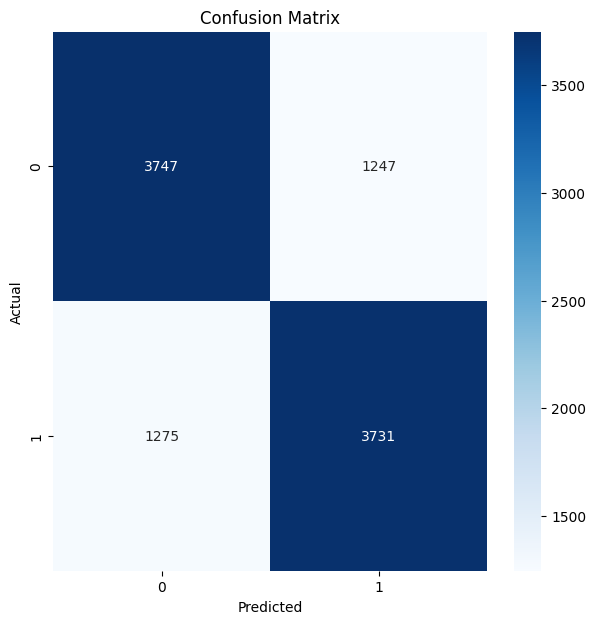

accuracy: 0.7478
classification report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      4994
           1       0.75      0.75      0.75      5006

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000
 


LinearSVC:

train score is 0.8697666666666667, test score is 0.7397


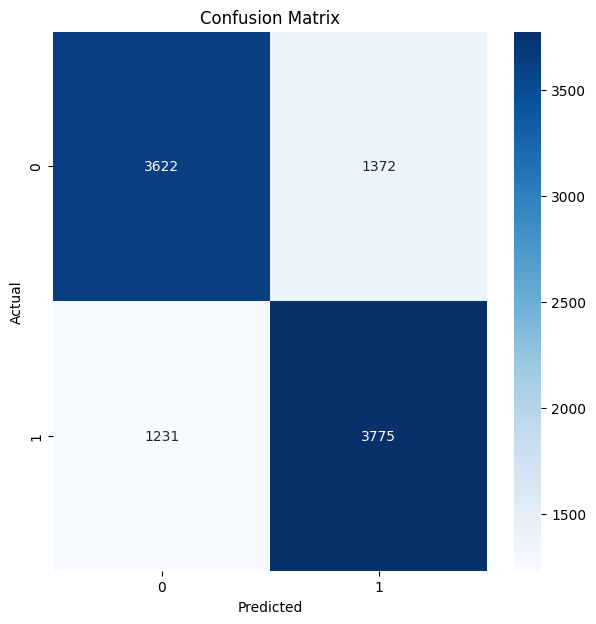

accuracy: 0.7397
classification report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      4994
           1       0.73      0.75      0.74      5006

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000
 




In [41]:
trained_models = {}
for name, model in models.items():
    print(f'{name}:\n')
    model = fit_predict(model, x_train_v, y_train, x_test_v, y_test)
    #trained_models[name] = deepcopy(model)

# predict using Hugging face transformers

In [43]:
from transformers import pipeline

In [46]:
model_path = '5CD-AI/Vietnamese-Sentiment-visobert'
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)
sentiment_task(df['text'][839945])

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'POS', 'score': 0.9987452030181885}]

In [47]:
df['target'][839945]

1